# OmniCount-191 Dataset Exploration

This notebook explores the OmniCount-191 dataset to understand:
- Dataset statistics (object counts, categories, distributions)
- Object type labels and their quality
- Spatial patterns and annotations
- Data quality issues

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image
import seaborn as sns

from dataset import OmniCountDataset, SpatialSorter
from utils import VisualMarker

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Dataset Configuration

In [2]:
# Configure dataset path
DATASET_ROOT = '/media/M2SSD/OmniCount-191/OmniCount-191'

# Available categories
ALL_CATEGORIES = ['Supermarket', 'Urban', 'Fruits', 'Wild', 'Satellite',
                  'Vegetables', 'Birds', 'Pets', 'Household']

print(f"Dataset root: {DATASET_ROOT}")
print(f"Available categories: {ALL_CATEGORIES}")

Dataset root: /media/M2SSD/OmniCount-191/OmniCount-191
Available categories: ['Supermarket', 'Urban', 'Fruits', 'Wild', 'Satellite', 'Vegetables', 'Birds', 'Pets', 'Household']


## 2. Load Dataset Statistics

In [3]:
def get_category_stats(dataset_root, category, split='train'):
    """Get statistics for a specific category."""
    cat_path = Path(dataset_root) / category / split
    annotation_file = cat_path / '_annotations.coco.json'
    
    if not annotation_file.exists():
        return None
    
    with open(annotation_file, 'r') as f:
        data = json.load(f)
    
    # Build category mapping
    cat_id_to_name = {c['id']: c['name'] for c in data['categories']}
    
    # Group annotations by image
    image_to_anns = defaultdict(list)
    for ann in data['annotations']:
        image_to_anns[ann['image_id']].append(ann)
    
    # Collect statistics
    object_counts = []
    object_types = []
    images_per_type = defaultdict(int)
    
    for img_info in data['images']:
        img_id = img_info['id']
        if img_id not in image_to_anns:
            continue
        
        anns = image_to_anns[img_id]
        object_counts.append(len(anns))
        
        # Get object types in this image
        types_in_image = [cat_id_to_name[ann['category_id']] for ann in anns]
        object_types.extend(types_in_image)
        
        # Track primary object type per image
        primary_type = Counter(types_in_image).most_common(1)[0][0]
        images_per_type[primary_type] += 1
    
    return {
        'category': category,
        'split': split,
        'num_images': len([img for img in data['images'] if img['id'] in image_to_anns]),
        'num_annotations': len(data['annotations']),
        'object_counts': object_counts,
        'object_types': Counter(object_types),
        'images_per_type': dict(images_per_type),
        'unique_object_types': len(cat_id_to_name),
        'all_categories': list(cat_id_to_name.values())
    }

# Collect stats for all categories
all_stats = {}
for category in ALL_CATEGORIES:
    for split in ['train', 'valid', 'test']:
        stats = get_category_stats(DATASET_ROOT, category, split)
        if stats:
            all_stats[f"{category}_{split}"] = stats

print(f"Loaded statistics for {len(all_stats)} category-split combinations")

Loaded statistics for 24 category-split combinations


## 3. Overall Dataset Statistics

In [4]:
# Summary table
print("=" * 100)
print(f"{'Category':<15} {'Split':<8} {'Images':<10} {'Annotations':<12} {'Unique Types':<15} {'Avg Count':<12}")
print("=" * 100)

for key, stats in all_stats.items():
    if stats:
        avg_count = np.mean(stats['object_counts'])
        print(f"{stats['category']:<15} {stats['split']:<8} {stats['num_images']:<10} "
              f"{stats['num_annotations']:<12} {stats['unique_object_types']:<15} {avg_count:<12.1f}")

print("=" * 100)

Category        Split    Images     Annotations  Unique Types    Avg Count   
Supermarket     train    5249       68590        53              13.1        
Supermarket     valid    492        7108         53              14.4        
Supermarket     test     251        3610         53              14.4        
Urban           train    7000       37279        13              5.3         
Urban           valid    2000       10889        13              5.4         
Urban           test     1000       5352         13              5.4         
Fruits          train    2424       11444        8               4.7         
Fruits          valid    303        1429         8               4.7         
Fruits          test     303        1429         8               4.7         
Wild            train    6675       22912        4               3.4         
Wild            valid    507        1762         4               3.5         
Wild            test     255        862          4              

## 4. Object Count Distribution

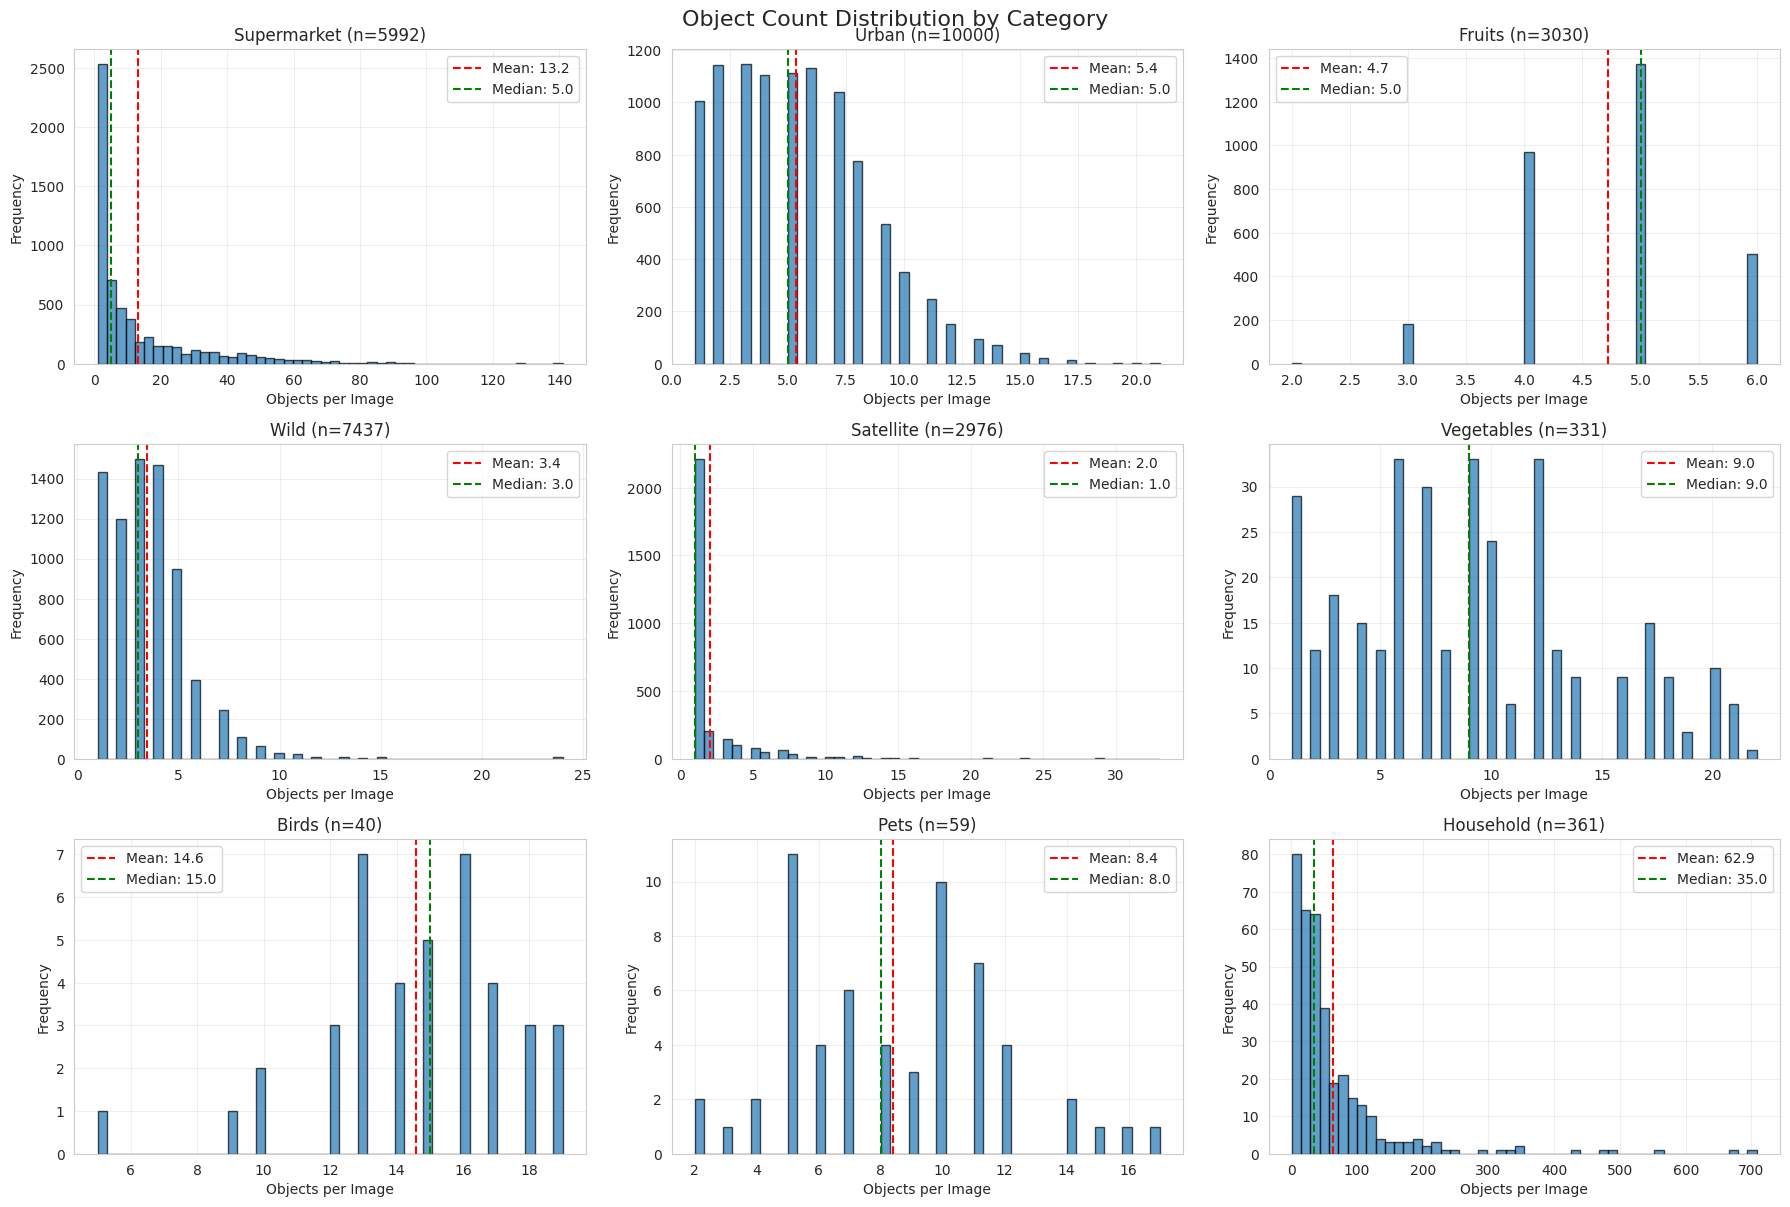

In [5]:
# Plot object count distributions
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, category in enumerate(ALL_CATEGORIES):
    ax = axes[idx]
    
    # Combine train/valid/test
    all_counts = []
    for split in ['train', 'valid', 'test']:
        key = f"{category}_{split}"
        if key in all_stats:
            all_counts.extend(all_stats[key]['object_counts'])
    
    if all_counts:
        ax.hist(all_counts, bins=50, alpha=0.7, edgecolor='black')
        ax.set_title(f"{category} (n={len(all_counts)})")
        ax.set_xlabel('Objects per Image')
        ax.set_ylabel('Frequency')
        ax.axvline(np.mean(all_counts), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(all_counts):.1f}')
        ax.axvline(np.median(all_counts), color='green', linestyle='--', 
                   label=f'Median: {np.median(all_counts):.1f}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Object Count Distribution by Category', y=1.002, fontsize=16)
plt.show()

## 5. Object Type Analysis


Object Types in Supermarket (train)
Total unique types: 53
Total annotations: 68590

Top 20 object types:
--------------------------------------------------------------------------------
Coffee                         Count: 25223  Images: 813   
Drinks                         Count: 16367  Images: 444   
Beans                          Count: 8006   Images: 330   
eggs                           Count: 7243   Images: 834   
Detergent                      Count: 2535   Images: 279   
Meat                           Count: 1176   Images: 252   
Juice                          Count: 676    Images: 180   
apples                         Count: 619    Images: 223   
Yogurt                         Count: 554    Images: 111   
Mushroom                       Count: 435    Images: 66    
Cheese                         Count: 411    Images: 183   
Avocado                        Count: 399    Images: 21    
banana                         Count: 333    Images: 48    
Orange                         C

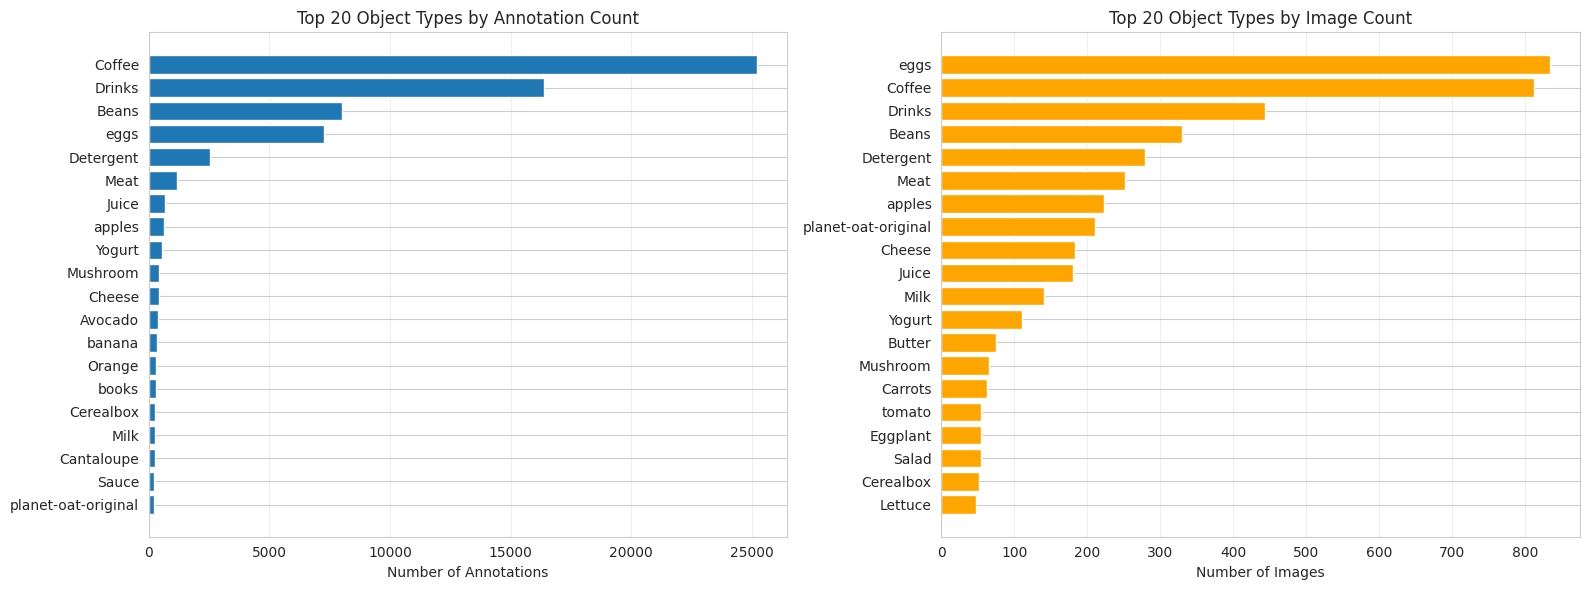

In [6]:
# Analyze object types for a specific category
def analyze_object_types(category='Supermarket', split='train', top_n=20):
    """Show top N object types in a category."""
    key = f"{category}_{split}"
    if key not in all_stats:
        print(f"No data for {key}")
        return
    
    stats = all_stats[key]
    
    print(f"\n{'='*80}")
    print(f"Object Types in {category} ({split})")
    print(f"{'='*80}")
    print(f"Total unique types: {stats['unique_object_types']}")
    print(f"Total annotations: {stats['num_annotations']}")
    print(f"\nTop {top_n} object types:")
    print(f"{'-'*80}")
    
    for obj_type, count in stats['object_types'].most_common(top_n):
        num_images = stats['images_per_type'].get(obj_type, 0)
        print(f"{obj_type:<30} Count: {count:<6} Images: {num_images:<6}")
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart of top N types by annotation count
    top_types = stats['object_types'].most_common(top_n)
    types, counts = zip(*top_types)
    ax1.barh(range(len(types)), counts)
    ax1.set_yticks(range(len(types)))
    ax1.set_yticklabels(types)
    ax1.set_xlabel('Number of Annotations')
    ax1.set_title(f'Top {top_n} Object Types by Annotation Count')
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Bar chart of top N types by image count
    top_image_types = sorted(stats['images_per_type'].items(), 
                            key=lambda x: x[1], reverse=True)[:top_n]
    types_img, counts_img = zip(*top_image_types)
    ax2.barh(range(len(types_img)), counts_img, color='orange')
    ax2.set_yticks(range(len(types_img)))
    ax2.set_yticklabels(types_img)
    ax2.set_xlabel('Number of Images')
    ax2.set_title(f'Top {top_n} Object Types by Image Count')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

# Analyze Supermarket category
analyze_object_types('Supermarket', 'train', top_n=20)

## 6. Sample Visualization with Different Orderings

Loaded 1996 samples

Sample 0:
  Category: Supermarket
  Object Type: eggs
  Count: 7


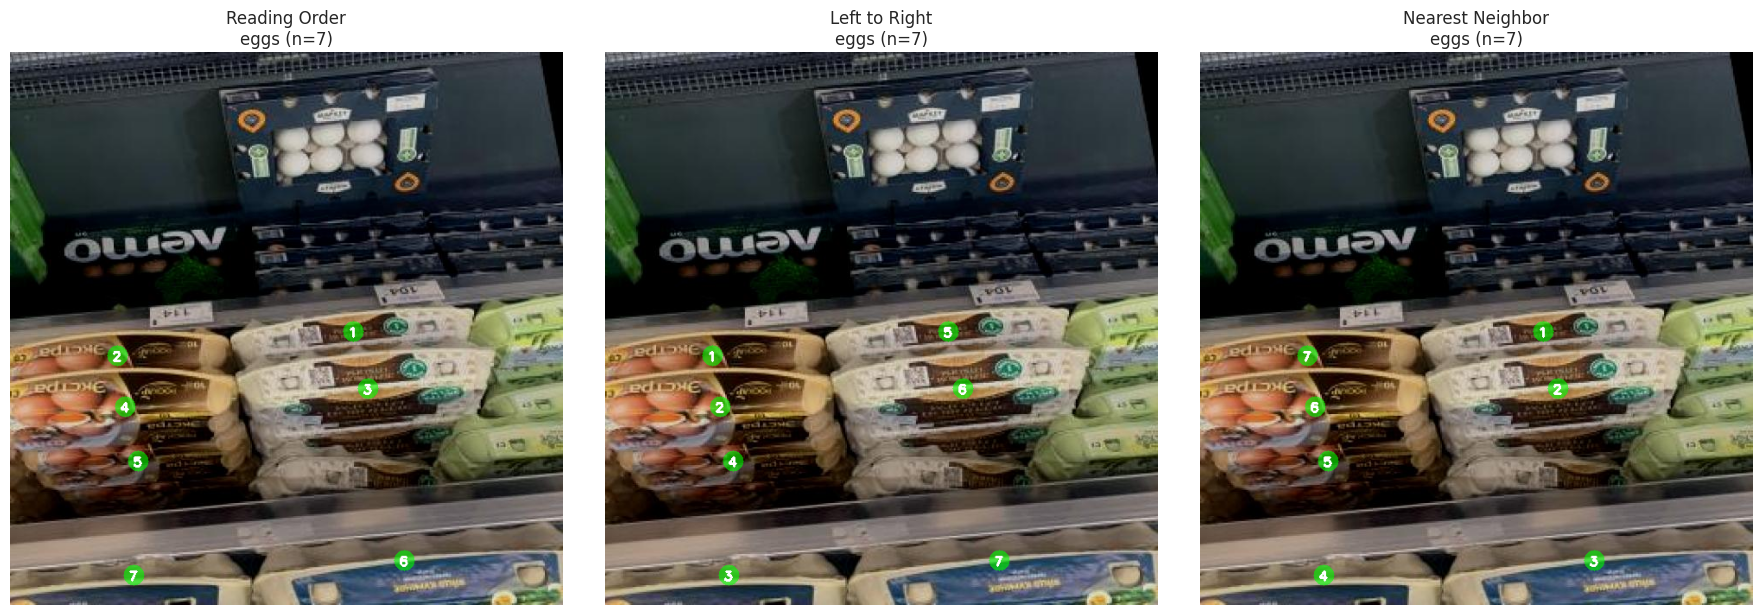


Sample 1:
  Category: Supermarket
  Object Type: Drinks
  Count: 13


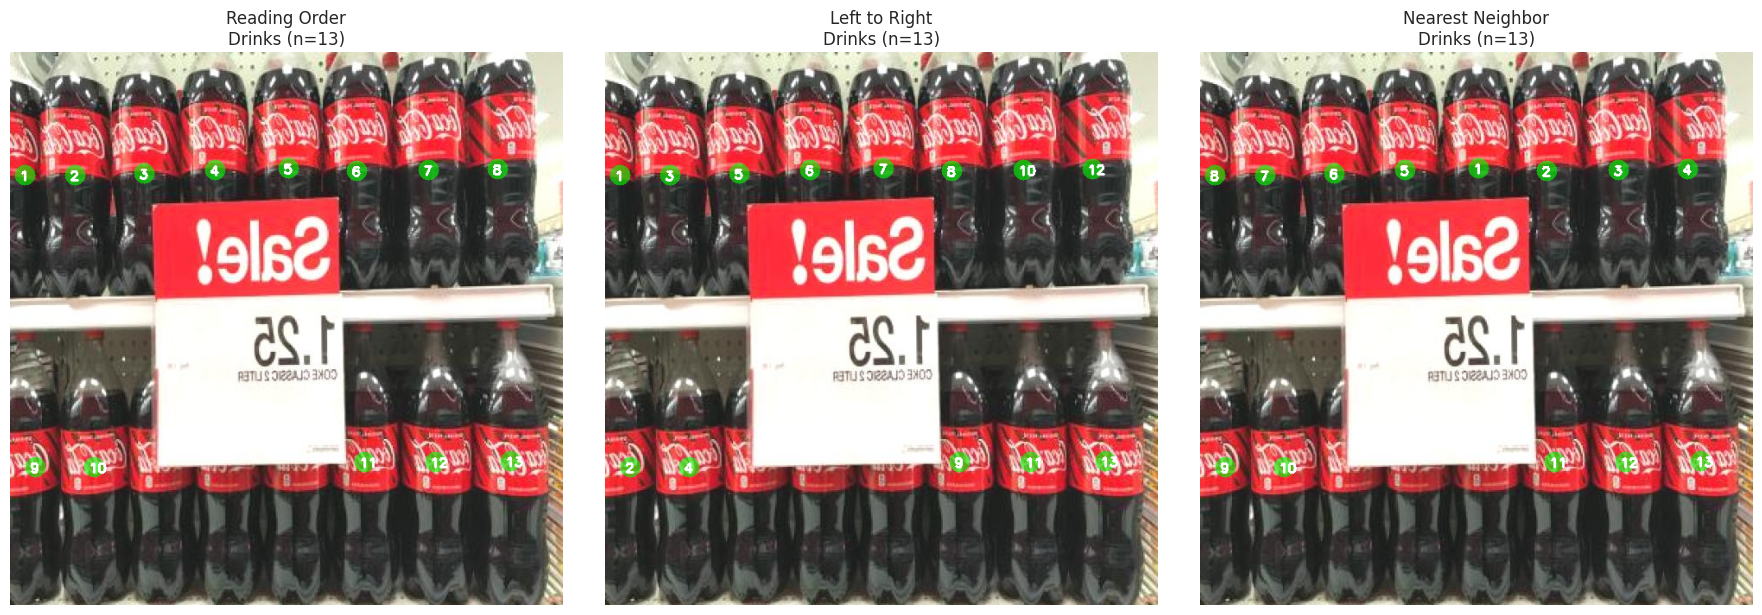


Sample 2:
  Category: Supermarket
  Object Type: Beans
  Count: 8


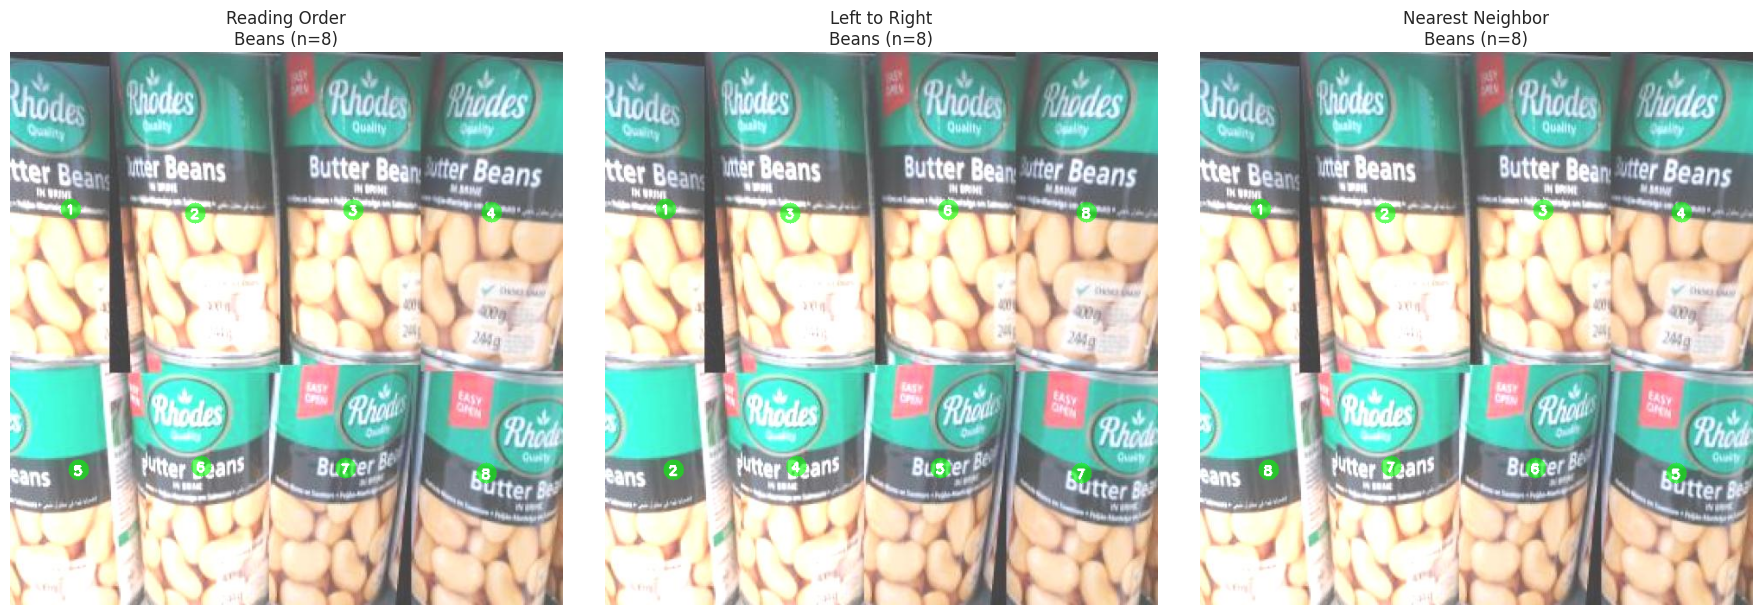

In [7]:
# Load dataset
dataset = OmniCountDataset(
    dataset_root=DATASET_ROOT,
    categories=['Supermarket'],
    split='train',
    spatial_order='reading_order',
    min_objects=5,
    max_objects=30
)

print(f"Loaded {len(dataset)} samples")

# Visualize a sample with different ordering strategies
def visualize_sample_with_orderings(sample_idx=0):
    """Show the same image with different spatial orderings."""
    img, points, meta = dataset[sample_idx]
    
    print(f"\nSample {sample_idx}:")
    print(f"  Category: {meta['category']}")
    print(f"  Object Type: {meta['object_type']}")
    print(f"  Count: {meta['num_objects']}")
    
    # Get unsorted points
    example = dataset.examples[sample_idx]
    unsorted_points = example['points']
    
    # Apply different orderings
    sorter = SpatialSorter()
    orderings = {
        'Reading Order': sorter.reading_order(unsorted_points),
        'Left to Right': sorter.left_to_right(unsorted_points),
        'Nearest Neighbor': sorter.nearest_neighbor(unsorted_points)
    }
    
    # Create marker
    marker = VisualMarker(strategy='numbers', alpha=0.7)
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for ax, (title, ordered_points) in zip(axes, orderings.items()):
        img_np = np.array(img)
        marked_img = marker.mark_image(img_np, ordered_points)
        
        ax.imshow(marked_img)
        ax.set_title(f"{title}\n{meta['object_type']} (n={len(ordered_points)})")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show multiple samples
for i in range(min(3, len(dataset))):
    visualize_sample_with_orderings(i)

## 7. Data Quality Analysis

In [8]:
# Check for potential annotation issues
def check_data_quality(category='Supermarket', split='train'):
    """Analyze potential data quality issues."""
    key = f"{category}_{split}"
    if key not in all_stats:
        return
    
    stats = all_stats[key]
    counts = stats['object_counts']
    
    print(f"\nData Quality Report: {category} ({split})")
    print("=" * 80)
    
    # Basic statistics
    print(f"\nObject Count Statistics:")
    print(f"  Min: {np.min(counts)}")
    print(f"  Max: {np.max(counts)}")
    print(f"  Mean: {np.mean(counts):.2f}")
    print(f"  Median: {np.median(counts):.2f}")
    print(f"  Std Dev: {np.std(counts):.2f}")
    
    # Distribution percentiles
    print(f"\nPercentiles:")
    for p in [10, 25, 50, 75, 90, 95, 99]:
        print(f"  {p}th: {np.percentile(counts, p):.1f}")
    
    # Outliers
    q1, q3 = np.percentile(counts, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = [c for c in counts if c < lower_bound or c > upper_bound]
    
    print(f"\nOutliers (using IQR method):")
    print(f"  Count: {len(outliers)} ({len(outliers)/len(counts)*100:.1f}%)")
    print(f"  Range: [{lower_bound:.1f}, {upper_bound:.1f}]")
    
    # Object type concentration
    print(f"\nObject Type Distribution:")
    print(f"  Total unique types: {stats['unique_object_types']}")
    top_5_count = sum(count for _, count in stats['object_types'].most_common(5))
    total_count = sum(stats['object_types'].values())
    print(f"  Top 5 types represent: {top_5_count/total_count*100:.1f}% of annotations")
    
    # Images per type
    images_per_type_values = list(stats['images_per_type'].values())
    print(f"\nImages per Object Type:")
    print(f"  Mean: {np.mean(images_per_type_values):.2f}")
    print(f"  Median: {np.median(images_per_type_values):.2f}")
    print(f"  Max: {np.max(images_per_type_values)}")
    print(f"  Min: {np.min(images_per_type_values)}")

# Check quality for each category
for category in ALL_CATEGORIES[:3]:  # Check first 3 categories
    check_data_quality(category, 'train')


Data Quality Report: Supermarket (train)

Object Count Statistics:
  Min: 1
  Max: 141
  Mean: 13.07
  Median: 5.00
  Std Dev: 17.63

Percentiles:
  10th: 1.0
  25th: 1.0
  50th: 5.0
  75th: 17.0
  90th: 39.0
  95th: 51.0
  99th: 77.0

Outliers (using IQR method):
  Count: 477 (9.1%)
  Range: [-23.0, 41.0]

Object Type Distribution:
  Total unique types: 53
  Top 5 types represent: 86.6% of annotations

Images per Object Type:
  Mean: 102.92
  Median: 45.00
  Max: 834
  Min: 2

Data Quality Report: Urban (train)

Object Count Statistics:
  Min: 1
  Max: 21
  Mean: 5.33
  Median: 5.00
  Std Dev: 3.14

Percentiles:
  10th: 1.0
  25th: 3.0
  50th: 5.0
  75th: 7.0
  90th: 9.0
  95th: 11.0
  99th: 14.0

Outliers (using IQR method):
  Count: 106 (1.5%)
  Range: [-3.0, 13.0]

Object Type Distribution:
  Total unique types: 13
  Top 5 types represent: 92.5% of annotations

Images per Object Type:
  Mean: 583.33
  Median: 32.00
  Max: 6163
  Min: 1

Data Quality Report: Fruits (train)

Object 

## 8. Interactive Sample Explorer

In [9]:
# Interactive sample browser
from ipywidgets import interact, IntSlider, Dropdown

# Load different categories
datasets = {}
for cat in ALL_CATEGORIES:
    try:
        ds = OmniCountDataset(
            dataset_root=DATASET_ROOT,
            categories=[cat],
            split='train',
            min_objects=1,
            max_objects=150
        )
        if len(ds) > 0:
            datasets[cat] = ds
    except Exception as e:
        print(f"Couldn't load {cat}: {e}")

marker = VisualMarker(strategy='numbers', alpha=0.7)

def explore_sample(category='Supermarket', sample_idx=0, num_marked=0):
    """Interactive sample explorer."""
    if category not in datasets:
        print(f"Category {category} not loaded")
        return
    
    dataset = datasets[category]
    sample_idx = min(sample_idx, len(dataset) - 1)
    
    img, points, meta = dataset[sample_idx]
    num_marked = min(num_marked, len(points))
    
    # Mark first num_marked points
    img_np = np.array(img)
    if num_marked > 0:
        marked_points = points[:num_marked]
        img_marked = marker.mark_image(img_np, marked_points)
    else:
        img_marked = img_np
    
    # Show image
    plt.figure(figsize=(12, 8))
    plt.imshow(img_marked)
    
    # Add info
    title = f"{meta['category']} - {meta['object_type']}\n"
    title += f"Total: {len(points)} | Marked: {num_marked} | "
    if num_marked < len(points):
        next_pt = points[num_marked]
        title += f"Next: ({next_pt[0]:.0f}, {next_pt[1]:.0f})"
    else:
        title += "DONE"
    
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print details
    print(f"\nImage size: {img.size}")
    print(f"Object type: {meta['object_type']}")
    print(f"Total objects: {len(points)}")

# Create interactive widget
category_dropdown = Dropdown(
    options=list(datasets.keys()),
    value=list(datasets.keys())[0],
    description='Category:'
)

interact(
    explore_sample,
    category=category_dropdown,
    sample_idx=IntSlider(min=0, max=100, step=1, value=0, description='Sample:'),
    num_marked=IntSlider(min=0, max=50, step=1, value=0, description='Marked:')
)

interactive(children=(Dropdown(description='Category:', options=('Supermarket', 'Urban', 'Fruits', 'Wild', 'Sa…

<function __main__.explore_sample(category='Supermarket', sample_idx=0, num_marked=0)>

## 9. Export Dataset Summary

In [10]:
# Create summary report
summary = {
    'total_images': sum(s['num_images'] for s in all_stats.values()),
    'total_annotations': sum(s['num_annotations'] for s in all_stats.values()),
    'categories': {},
}

for category in ALL_CATEGORIES:
    cat_data = {
        'splits': {},
        'total_images': 0,
        'total_annotations': 0,
    }
    
    for split in ['train', 'valid', 'test']:
        key = f"{category}_{split}"
        if key in all_stats:
            stats = all_stats[key]
            cat_data['splits'][split] = {
                'num_images': stats['num_images'],
                'num_annotations': stats['num_annotations'],
                'unique_types': stats['unique_object_types'],
                'avg_count': float(np.mean(stats['object_counts'])),
                'median_count': float(np.median(stats['object_counts'])),
            }
            cat_data['total_images'] += stats['num_images']
            cat_data['total_annotations'] += stats['num_annotations']
    
    summary['categories'][category] = cat_data

# Save to JSON
output_file = 'dataset_summary.json'
with open(output_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\nDataset summary saved to {output_file}")
print(f"\nOverall Statistics:")
print(f"  Total images: {summary['total_images']:,}")
print(f"  Total annotations: {summary['total_annotations']:,}")
print(f"  Avg annotations per image: {summary['total_annotations']/summary['total_images']:.1f}")


Dataset summary saved to dataset_summary.json

Overall Statistics:
  Total images: 30,226
  Total annotations: 205,489
  Avg annotations per image: 6.8


## 10. Custom Analysis

Use this cell for your own custom analysis and exploration.

In [11]:
# Your custom analysis here
